Instance segmentation using Unet and watershed

EM Dataset from https://www.epfl.ch/labs/cvlab/data/data-em/  
Mitochondria annotated

# Preprocessing

In [1]:
import tifffile
from pathlib import Path

import cv2
import matplotlib.pyplot as plt

In [2]:
images = tifffile.imread('./data/training.tif')
masks = tifffile.imread('./data/training_groundtruth.tif')
print(images.shape, masks.shape)

(165, 768, 1024) (165, 768, 1024)


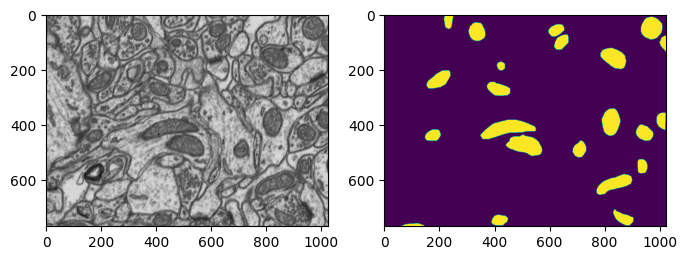

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

axes[0].imshow(images[0], cmap='gray')
axes[1].imshow(masks[0])
plt.show()

# Slice to small patches

Split .tif to small patches (256 x 256)  
This code saves individual patches in the `images` and `masks` folders under `data/generated_patches`.

In [4]:
slice_size = 256

In [5]:
save_dir = Path('./data/genedated_patches/')

img_dir = save_dir / 'images'
msk_dir = save_dir / 'masks'

if not img_dir.is_dir():
    img_dir.mkdir(parents=True, exist_ok=True)
if not msk_dir.is_dir():
    msk_dir.mkdir(parents=True, exist_ok=True)

In [6]:
for tif_idx, (img, msk) in enumerate(zip(images, masks), 1):
    slice_idx = 1
    for i in range(0, img.shape[0], slice_size):
        for j in range(0, img.shape[1], slice_size):
            cv2.imwrite(f"{img_dir}/tif_{tif_idx:03d}_{slice_idx:03d}.png",
                        img[i : i+slice_size, j : j+slice_size])
            cv2.imwrite(f"{msk_dir}/tif_{tif_idx:03d}_{slice_idx:03d}.png",
                        msk[i : i+slice_size, j : j+slice_size])
            slice_idx += 1

---

# Dataset & Training

Reuse code from previous work (004_Unet).

In [8]:
import sys
sys.path.append('./004_Unet/')

import torch

from main import main


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
class Config:
    seed = 42
    log_dir = './'
    data_path = str(save_dir) + '/'

    height = 128
    width = 128

    num_workers = 2
    batch_size = 32

    lr = 1e-3
    epochs = 50
    decay = 0

    early_stop = True
    early_stop_patience = 15

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
main(Config)

Done!
Valid Loss: 0.01199 | Valid IoU: 0.9214 | Total time: 774s
Trained model save at .//model.pth


# Result

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

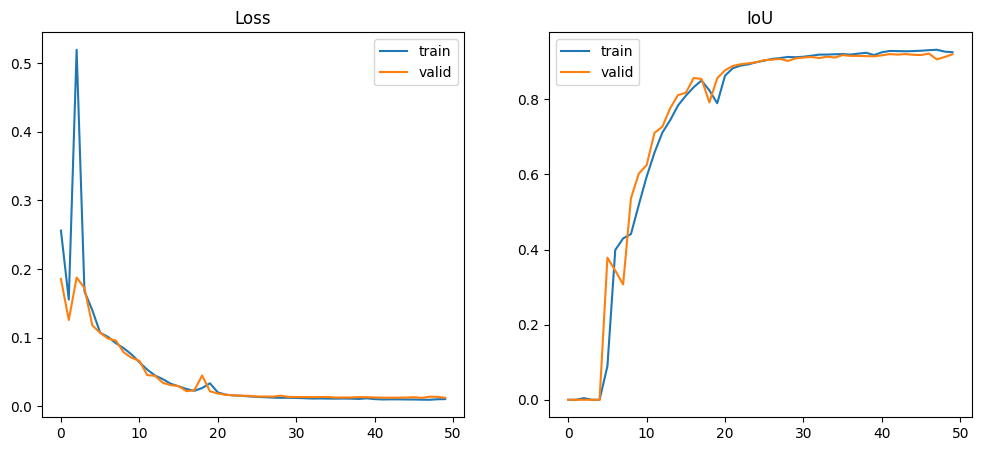

In [2]:
results = pd.read_csv('./results.txt')

train_results = results.query("phase=='train'").reset_index(drop=True)
valid_results = results.query("phase=='valid'").reset_index(drop=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(train_results['loss'], label='train')
axes[0].plot(valid_results['loss'], label='valid')
axes[0].set_title('Loss')
axes[0].legend()
axes[1].plot(train_results['IoU'], label='train')
axes[1].plot(valid_results['IoU'], label='valid')
axes[1].set_title('IoU')
axes[1].legend()
plt.show()

---

# Instance Segmentation

In [3]:
import sys
sys.path.append('./004_Unet/')

import tifffile

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from tqdm import tqdm

from model import Unet
from utils import intersection_over_union


device = 'cuda' if torch.cuda.is_available() else 'cpu'
slice_size = 256
scale_size = 2
threshold = 0.5

## Inference

In [4]:
test_images = tifffile.imread('./data/testing.tif')
test_masks = tifffile.imread('./data/testing_groundtruth.tif')

In [5]:
model = Unet(3, nb_classes=1).to(device)
model.load_state_dict(torch.load('model.pth',
                                 map_location=device))

<All keys matched successfully>

In [6]:
test_preds = torch.zeros_like(torch.tensor(test_images))
test_pred_probs = torch.empty_like(torch.tensor(test_images), dtype=torch.float)
ious = []

tk0 = tqdm(enumerate(zip(test_images, test_masks)),
           total=len(test_images), leave=True)
for idx, (test_image, test_mask) in tk0:
    for i in range(0, test_image.shape[0], slice_size):
        for j in range(0, test_image.shape[1], slice_size):
            patch = test_image[i:i+slice_size, j:j+slice_size] / 255
            patch = cv2.resize(patch, (slice_size//scale_size, slice_size//scale_size),
                               interpolation=cv2.INTER_AREA)
            patch = torch.tensor(patch, dtype=torch.float)
            patch = torch.stack((patch, patch, patch)).unsqueeze(0)

            out = model(patch)
            out = out.squeeze().sigmoid().detach().cpu().numpy()
            out = cv2.resize(out, (slice_size, slice_size),
                             interpolation=cv2.INTER_CUBIC)
            out = torch.tensor(out)

            test_preds[idx, i:i+slice_size, j:j+slice_size] = out > threshold
            test_pred_probs[idx, i:i+slice_size, j:j+slice_size] = out

    ious.append(
        intersection_over_union(
            torch.tensor(test_mask), test_preds[idx]
            )
        )

print(f"\nMean IoU on test images: {np.mean(ious):.4f}")

  0%|          | 0/165 [00:00<?, ?it/s]

100%|██████████| 165/165 [02:11<00:00,  1.26it/s]


Mean IoU on test images: 0.6450


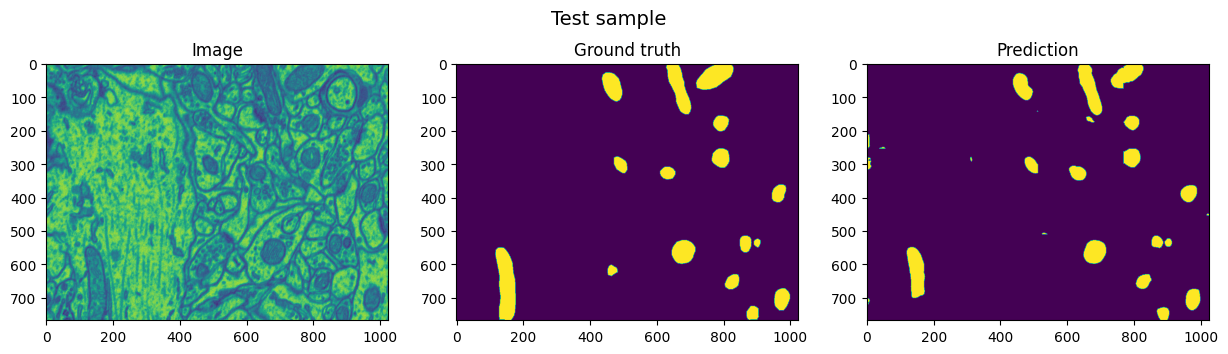

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

axes[0].imshow(test_images[92]) 
axes[0].set_title("Image")
axes[1].imshow(test_masks[92])
axes[1].set_title("Ground truth")
axes[2].imshow(test_preds[92])
axes[2].set_title("Prediction")
plt.suptitle("Test sample", y=0.8, fontsize=14)
plt.show()

## Instance segmentation with Watershed
on one sample

In [8]:
sample_output = (test_pred_probs[92].numpy() * 255).astype(np.uint8)

# Erase small noise
# Binarize image with Otsu thresholding, and apply Opening(erosion followed by dilation).
_, thresh = cv2.threshold(sample_output, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
kernel = np.ones((3, 3), dtype=np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Dilate images to find 'sure background'
sure_bg = cv2.dilate(opening, kernel, iterations=10)

# Find 'sure foreground' using distance transform. 
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, dist_transform.max()*0.2, 255, 0)
sure_fg = sure_fg.astype(np.uint8)

# Between sure back ground and sure foreground is unknown ambiguous region
unknown = cv2.subtract(sure_bg, sure_fg)

# Label the foreground regions to positive value
_, markers = cv2.connectedComponents(sure_fg)

# Lift the all values by 10 to seperate background and unknown region.
# This is because cv2.watershed determine all 0 value as unknwon.
markers += 10
markers[unknown==255] = 0

# Apply watershed filling
sample_results = np.moveaxis(
    np.stack([sample_output, sample_output, sample_output]),
    0, -1
)
markers = cv2.watershed(sample_results, markers)

For visibility, change color of each regions.

In [9]:
sample_img = np.moveaxis(
    np.stack([test_images[92], test_images[92], test_images[92]]),
    0, -1
)
sample_img[markers==-1] = [0, 0, 255]

cmap = plt.cm.hsv(np.linspace(0, 1, markers.max()+1))
sample_seg = np.zeros((*markers.shape, 3))
sample_seg[..., 0] = markers
for i in range(sample_seg.shape[0]):
    for j in range(sample_seg.shape[1]):
        if sample_seg[i, j, 0] == 10:
            sample_seg[i, j] = [1, 1, 1]
        else:
            sample_seg[i, j] = cmap[int(sample_seg[i, j, 0])][:-1]

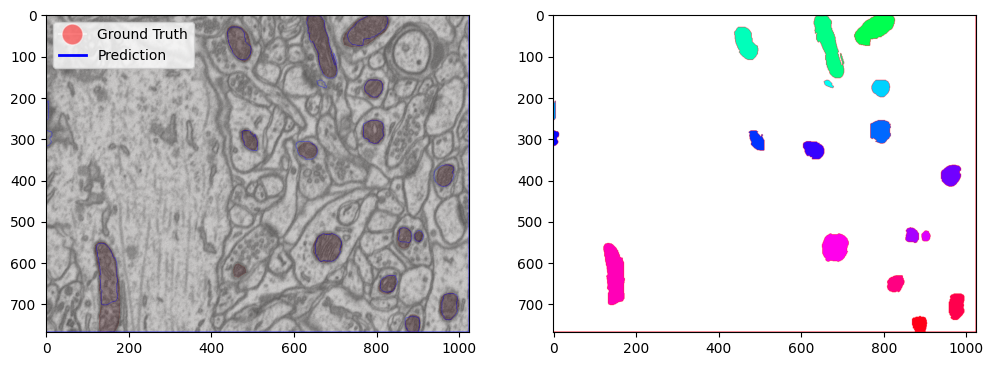

In [10]:
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Ground Truth',
                          markerfacecolor='r', markersize=15, alpha=0.5),
                   Line2D([0], [0], color='b', linewidth=2, label='Prediction')]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(sample_img)
axes[0].imshow(test_masks[92], cmap='Reds', alpha=0.15)
axes[0].legend(handles=legend_elements, loc='upper left')
axes[1].imshow(sample_seg)
plt.show()